In [1]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy
import scvi
from scvi.dataset import CortexDataset, RetinaDataset, CsvDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
from scvi.dataset.utils import setup_anndata

#STUFF THAT I MESSED AROUND WITH
# from BioDataset import BioDataset
# from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


In [2]:
save_path = "data/"
gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()

adata = gene_dataset.to_anndata()


[2020-06-23 18:31:15,882] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/expression.bin already downloaded
[2020-06-23 18:31:15,883] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-06-23 18:31:25,317] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2020-06-23 18:31:26,396] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-23 18:31:26,397] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-23 18:31:28,207] INFO - scvi.dataset.dataset | Downsampling from 19972 to 1000 genes
[2020-06-23 18:31:28,330] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-23 18:31:28,345] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-23 18:31:28,411] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-23 18:31:28,416] INFO - scvi.dataset.dataset | Downsampled from 3005 to 3005 cells
[2020-06-23 18:31:28,432] INFO - scvi.dataset.dataset | Making gen

In [3]:
adata = gene_dataset.to_anndata()

adata.obs['batch_indices'][:50] = 1

setup_anndata(adata,batch_key='batch_indices', labels_key = 'precise_labels' )


[2020-06-23 18:31:28,539] INFO - scvi.dataset.utils | Using data from adata.X
[2020-06-23 18:31:28,540] INFO - scvi.dataset.utils | Using batches from adata.obs["batch_indices"]
[2020-06-23 18:31:28,541] INFO - scvi.dataset.utils | Using labels from adata.obs["precise_labels"]
[2020-06-23 18:31:28,546] INFO - scvi.dataset.utils | Computing library size prior per batch
[2020-06-23 18:31:28,556] INFO - scvi.dataset.utils | Successfully registered anndata object containing 3005 cells, 1000 genes, and 2 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [4]:
adata.uns['scvi_data_registry']

{'X': (None, 'X'),
 'batch_indices': ('obs', 'batch_indices'),
 'local_l_mean': ('obs', '_scvi_local_l_mean'),
 'local_l_var': ('obs', '_scvi_local_l_var'),
 'labels': ('obs', '_scvi_labels')}

In [5]:
adata.uns['scvi_summary_stats']['n_batch']

2

In [9]:
n_epochs = 10
lr = 1e-3
use_cuda = True

#nbatch, ngenes, nproteins
vae = VAE(adata.shape[1], n_batch = adata.uns['scvi_summary_stats']['n_batch'])
trainer = UnsupervisedTrainer(
    vae,
    adata,
    train_size=0.90,
    n_epochs_kl_warmup = 2,
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs = n_epochs)

[2020-06-23 19:03:51,671] INFO - scvi.inference.inference | KL warmup for 2 epochs


In [ ]:
%matplotlib inline

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 10, (len(elbo_train_set)))
plt.plot(x, elbo_train_set, label="train")
plt.plot(x, elbo_test_set, label="test")
# plt.ylim(1500, 3000)
plt.legend()


In [10]:
full = trainer.create_posterior(trainer.model, adata, indices=np.arange(len(gene_dataset)))
full = full.update({"batch_size":32})

In [11]:
import time
a = time.time()
for d, e in enumerate(full):
    pass
b = time.time()
b-a

0.44031715393066406

In [ ]:
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [ ]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [ ]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

In [ ]:
n_samples = 100
M_permutation = 100000

In [ ]:
de_res = full.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=n_samples,
    M_permutation=M_permutation,
)


In [ ]:
de_res

In [ ]:
genes_of_interest = ["thy1", "mbp"]
de_res.filter(items=genes_of_interest, axis=0)

In [ ]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

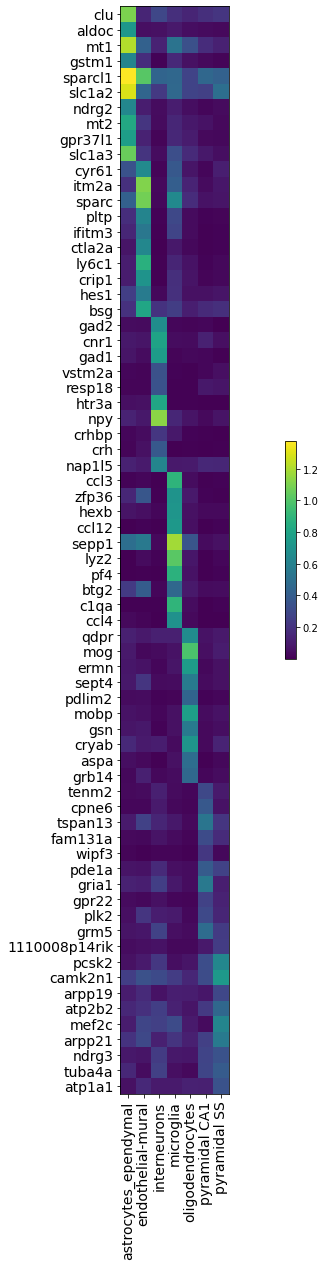

In [33]:
%matplotlib inline
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='viridis', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)


In [3]:
from scvi.dataset import  DownloadableAnnDataset, GeneExpressionDataset
save_path = "data/"
dataset1 = DownloadableAnnDataset(
    "pbmc_10k_protein.h5ad",
    save_path=save_path,
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

dataset2 = DownloadableAnnDataset(
    "pbmc_5k_protein.h5ad",
    save_path=save_path,
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_5k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

[2020-06-19 12:36:04,228] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/pbmc_10k_protein.h5ad already downloaded
[2020-06-19 12:36:05,973] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-19 12:36:05,974] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-19 12:36:07,317] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-19 12:36:07,650] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-06-19 12:36:07,683] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/pbmc_5k_protein.h5ad already downloaded
[2020-06-19 12:36:08,810] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-19 12:36:08,811] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-19 12:36:09,583] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-19 12:36:09,793] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [4]:
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

In [5]:
# concatenate the datasets
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset1, dataset2])
dataset.subsample_genes(4000)

[2020-06-19 12:36:09,888] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-06-19 12:36:09,888] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-06-19 12:36:09,914] INFO - scvi.dataset.dataset | Keeping 15792 genes
[2020-06-19 12:36:12,252] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-19 12:36:13,450] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-19 12:36:13,452] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-19 12:36:14,761] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-19 12:36:15,399] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-19 12:36:15,400] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-19 12:36:18,452] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-19 12:36:18,454] INFO - 

In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 10849 x 4000
    gene_attribute_names: 'gene_names', 'n_cells', 'highly_variable', 'encode', 'hvg_encode'
    cell_attribute_names: 'local_means', 'n_counts', 'local_vars', 'labels', 'batch_indices', 'percent_mito', 'n_genes', 'protein_expression'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [7]:
adata  = dataset.to_anndata()

In [8]:
adata

AnnData object with n_obs × n_vars = 10849 × 4000
    obs: 'n_counts', 'cell_types', 'batch_indices', 'percent_mito', 'n_genes'
    var: 'n_cells', 'highly_variable', 'encode', 'hvg_encode'
    uns: 'cell_measurements_col_mappings', 'protein_names'
    obsm: 'protein_expression'

In [9]:
adata.obsm['protein_expression']

array([[   7,  491,   61, ...,   13,    9,    4],
       [   8,  472,  102, ...,   19,    9,    9],
       [  12, 1289,  128, ...,   10,   20,   11],
       ...,
       [   7,   15,    6, ...,  737,   34,   14],
       [ 145,    9,   14, ...,    8,   11,    2],
       [   0,  382,    1, ...,    3,    3,    1]])

In [10]:
adata.uns['protein_names']

array(['CD127_TotalSeqB', 'CD14_TotalSeqB', 'CD15_TotalSeqB',
       'CD16_TotalSeqB', 'CD19_TotalSeqB', 'CD25_TotalSeqB',
       'CD3_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB',
       'CD4_TotalSeqB', 'CD56_TotalSeqB', 'CD8a_TotalSeqB',
       'PD-1_TotalSeqB', 'TIGIT_TotalSeqB'], dtype='<U16')

In [11]:
setup_anndata(adata, protein_expression_obsm_key = 'protein_expression', batch_key = 'batch_indices')

[2020-06-19 12:36:28,814] INFO - scvi.dataset.utils | Using data from adata.X
[2020-06-19 12:36:28,815] INFO - scvi.dataset.utils | Using batches from adata.obs["batch_indices"]
[2020-06-19 12:36:28,816] INFO - scvi.dataset.utils | No label_key inputted, assuming all cells have same label
[2020-06-19 12:36:28,818] INFO - scvi.dataset.utils | Computing library size prior per batch
0        0
1        0
2        0
3        0
4        0
        ..
10844    1
10845    1
10846    1
10847    1
10848    1
Name: batch_indices, Length: 10849, dtype: uint16
batch_indices
[2020-06-19 12:36:28,891] INFO - scvi.dataset.utils | Successfully registered anndata object containing 10849 cells, 4000 genes, and 2 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels', 'protein_expression']


In [27]:
test_mode = False

totalvae = TOTALVI(
    adata.uns['scvi_summary_stats']['n_genes'], 
    adata.uns['scvi_summary_stats']['n_proteins'], 
    0
#     adata.uns['scvi_summary_stats']['n_batch'],
)
use_cuda = True
lr = 4e-3
n_epochs = 500

# totalVI is trained on 90% of the data
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
trainer = TotalTrainer(
    totalvae,
    adata,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    batch_size=256,
    early_stopping_kwargs="auto" if not test_mode else None
)

NameError: name 'TOTALVI' is not defined

In [15]:
trainer.train(n_epochs = 10)

> /Users/galen/scVI/scvi/inference/total_inference.py(188)compute_elbo()
-> x, local_l_mean, local_l_var, batch_index, labels, y = self._unpack_tensors(tensors)


(Pdb)  c


here
> /Users/galen/scVI/scvi/inference/total_inference.py(161)_unpack_tensors()
-> return x, local_l_mean, local_l_var, batch_index, labels, y


(Pdb)  c


> /Users/galen/scVI/scvi/models/totalvi.py(444)inference()
-> qz_m, qz_v, ql_m, ql_v, latent, untran_latent = self.encoder(


(Pdb)  c


> /Users/galen/scVI/scvi/models/modules.py(122)forward()
-> if cat.size(1) != n_cat:


(Pdb)  cat


tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 1., 1., 

(Pdb)  cat.size


<built-in method size of Tensor object at 0x15fa36048>


(Pdb)  cat.size()


torch.Size([256])


(Pdb)  n_cat_list


*** NameError: name 'n_cat_list' is not defined


(Pdb)  self.n_cat_list


[2]


(Pdb)  c


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

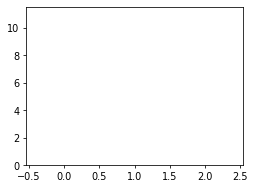

In [37]:
import matplotlib.pyplot as plt
w = 4
h = 3
d = 70
plt.figure(figsize=(w, h), dpi=d)
means = (10, 11, 9)
positions = [0, 1, 2]
std = (1, 2, 3)

plt.bar(positions, means, color="w",)
plt.show()